In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_series(time, series, start=0, end=None, format='-'):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel('Time')
    plt.ylabel('Series')
    plt.grid(True)

In [3]:
def trend(time, slope=0):
    return slope * time

In [4]:
def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

In [5]:
from random import randrange

def white_noise (time):
    series = np.random.randn(len(time))
    return series

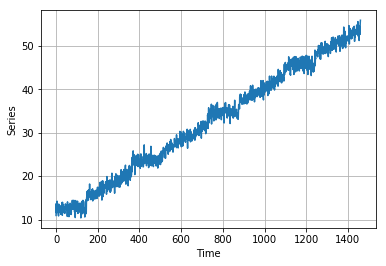

In [6]:
time = np.arange(4 * 365 + 1, dtype="float32")

baseline = 10
slope = 0.03
amplitude = 2

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += white_noise(time)

plot_series (time, series)

In [16]:
split_point = 1000
window_size = 20
window_shift_size = 1
shuffle_buffer = 900
batch_size = 32

time_train = time[0:split_point]
series_train = series[0:split_point]

time_val = time[split_point:]
series_val = series[split_point:]

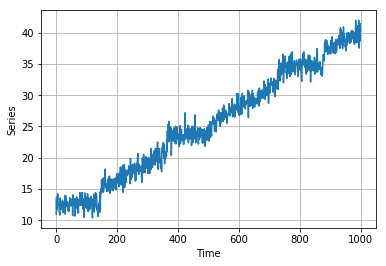

In [17]:
plot_series (time_train, series_train)

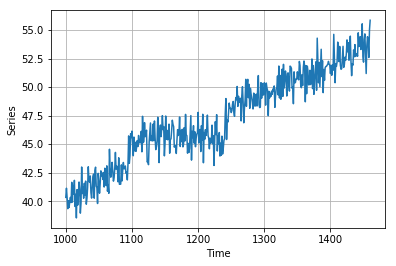

In [18]:
plot_series (time_val, series_val)

In [19]:
def windowed_dataset(series, window_size, shift_size, shuffle_buffer, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(size=window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
    dataset = dataset.shuffle(buffer_size=shuffle_buffer)
    dataset = dataset.batch(batch_size=batch_size, drop_remainder=True).prefetch(1)
    return dataset

In [20]:
dataset = windowed_dataset(series_train, window_size, window_shift_size, shuffle_buffer, batch_size)

In [21]:
model = tf.keras.models.Sequential()
layer = tf.keras.layers.Dense(1, input_shape=[window_size])
model.add(layer)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-6), loss='mse', metrics=['accuracy'])
model.summary()

model.fit(dataset, epochs=100, verbose=1)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 21        
Total params: 21
Trainable params: 21
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
30/30 [==============================] - 0s 15ms/step - loss: 5.0330 - accuracy: 0.0000e+00
Epoch 2/100
30/30 [==============================] - 0s 5ms/step - loss: 3.1862 - accuracy: 0.0000e+00
Epoch 3/100
30/30 [==============================] - 0s 5ms/step - loss: 2.8651 - accuracy: 0.0000e+00
Epoch 4/100
30/30 [==============================] - 0s 5ms/step - loss: 2.8105 - accuracy: 0.0000e+00
Epoch 5/100
30/30 [==============================] - 0s 5ms/step - loss: 2.8016 - accuracy: 0.0000e+00
Epoch 6/100
30/30 [==============================] - 0s 5ms/step - loss: 2.8003 - accuracy: 0.0000e+00
Epoch 7/100
30/30 [==============

30/30 [==============================] - 0s 5ms/step - loss: 2.7866 - accuracy: 0.0000e+00
Epoch 76/100
30/30 [==============================] - 0s 5ms/step - loss: 2.7864 - accuracy: 0.0000e+00
Epoch 77/100
30/30 [==============================] - 0s 5ms/step - loss: 2.7862 - accuracy: 0.0000e+00
Epoch 78/100
30/30 [==============================] - 0s 5ms/step - loss: 2.7860 - accuracy: 0.0000e+00
Epoch 79/100
30/30 [==============================] - 0s 5ms/step - loss: 2.7858 - accuracy: 0.0000e+00
Epoch 80/100
30/30 [==============================] - 0s 5ms/step - loss: 2.7856 - accuracy: 0.0000e+00
Epoch 81/100
30/30 [==============================] - 0s 5ms/step - loss: 2.7854 - accuracy: 0.0000e+00
Epoch 82/100
30/30 [==============================] - 0s 5ms/step - loss: 2.7852 - accuracy: 0.0000e+00
Epoch 83/100
30/30 [==============================] - 0s 5ms/step - loss: 2.7850 - accuracy: 0.0000e+00
Epoch 84/100
30/30 [==============================] - 0s 5ms/step - loss: 2.7

In [22]:
forecast = []
print ('Length of series is ',len(series))
print ('Window size is ', window_size)
for x in range(len(series)-window_size):
    forecast.append(model.predict(series[x:x+window_size][np.newaxis]))
    
# forecast is on entire series data. let's remove the data which was part of training and keep just the forecast for validation data
forecast = forecast[split_point-window_size:]

Length of series is  1461
Window size is  20


In [23]:
results = np.array(forecast)[:,0,0]

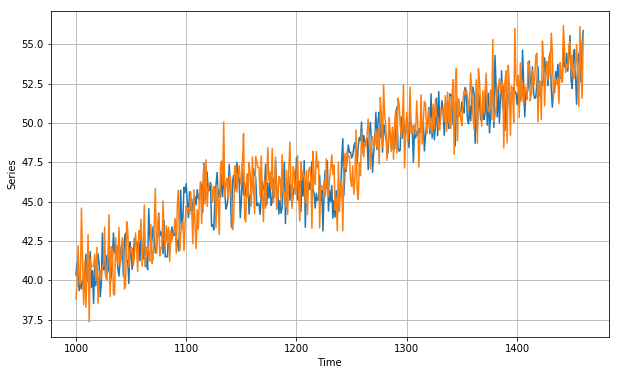

In [24]:
plt.figure(figsize=(10, 6))
plot_series(time_val, series_val)
plot_series(time_val, results)

In [25]:
tf.keras.metrics.mean_absolute_error(series_val, results).numpy()

1.3748009

In [56]:
import pandas as pd

future_forecast = []
start= 1461
starting_window = series_val[-window_size:][np.newaxis]
starting_window_series = pd.Series(starting_window)

#print (starting_window)
for i in range(0, 100):    
    
    starting_window = np.array(starting_window_series)
    prediction_window = starting_window[i:window_size]    
    
    predicted_value = model.predict(prediction_window)
    print ('predicted value is ', predicted_value)
    starting_window_series.append(predicted_value)
    
    #print (starting_window)
    np.append(time_val, start+i)
    np.append(series_val, predicted_value)

Exception: Data must be 1-dimensional